In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path = Path('images'); path

PosixPath('images')

In [4]:
def get_labels(file_path): return float(str(file_path).split(",")[1].split(".p")[0])

In [5]:
data_CLOSE = (ImageList.from_folder(path)
                .split_by_folder(train = "train_CLOSE", valid = "validation_CLOSE")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

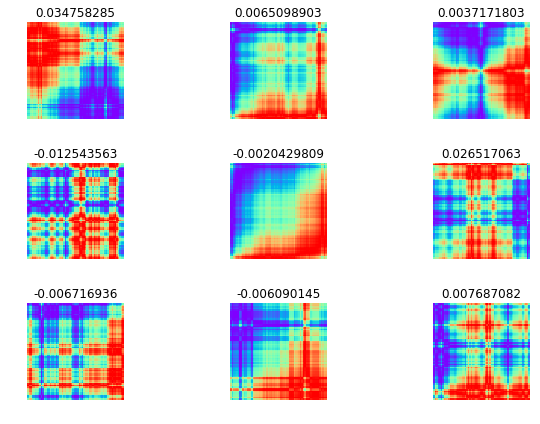

In [6]:
data_CLOSE.show_batch(3, figsize=(9,6))

In [7]:
learn_CLOSE = cnn_learner(data_CLOSE, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_CLOSE.load('CLOSE-stage1');

In [8]:
last_layers_CLOSE = list(children(learn_CLOSE.model))[-1][-1]
learn_CLOSE.model[-1] = learn_CLOSE.model[-1][:-1]
last_layers_CLOSE

Linear(in_features=512, out_features=1, bias=True)

In [9]:
data_percentage = (ImageList.from_folder(path)
                .split_by_folder(train = "train_percentage", valid = "validation_percentage")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

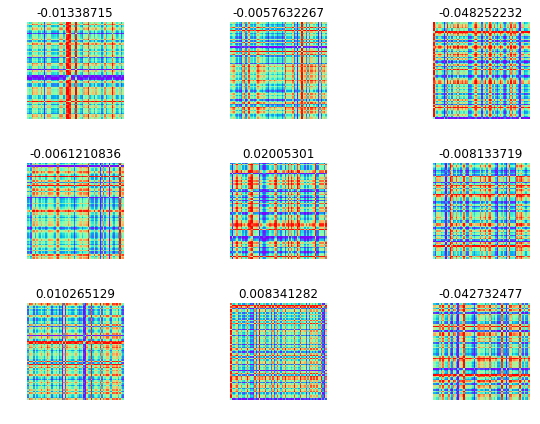

In [10]:
data_percentage.show_batch(3, figsize=(9,6))

In [11]:
learn_percentage = cnn_learner(data_percentage, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_percentage.load('percentage-stage1');

In [12]:
last_layers_percentage = list(children(learn_percentage.model))[-1][-1]
learn_percentage.model[-1] = learn_percentage.model[-1][:-1]
last_layers_percentage

Linear(in_features=512, out_features=1, bias=True)

In [13]:
data_RSI = (ImageList.from_folder(path)
                .split_by_folder(train = "train_RSI", valid = "validation_RSI")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

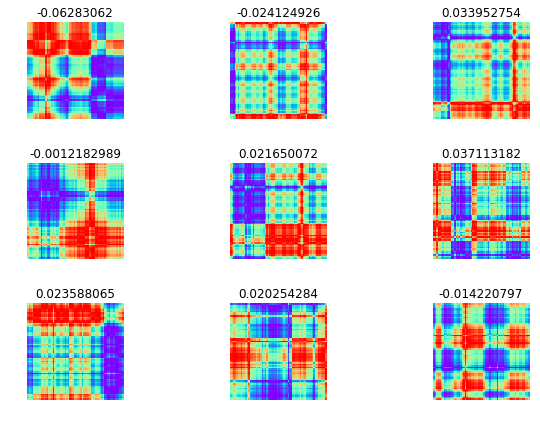

In [14]:
data_RSI.show_batch(3, figsize=(9,6))

In [15]:
learn_RSI = cnn_learner(data_RSI, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_RSI.load('RSI-stage1');

In [16]:
last_layers_RSI = list(children(learn_RSI.model))[-1][-1]
learn_RSI.model[-1] = learn_RSI.model[-1][:-1]
last_layers_RSI

Linear(in_features=512, out_features=1, bias=True)

In [17]:
data_BBdiff = (ImageList.from_folder(path)
                .split_by_folder(train = "train_BBdiff", valid = "validation_BBdiff")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

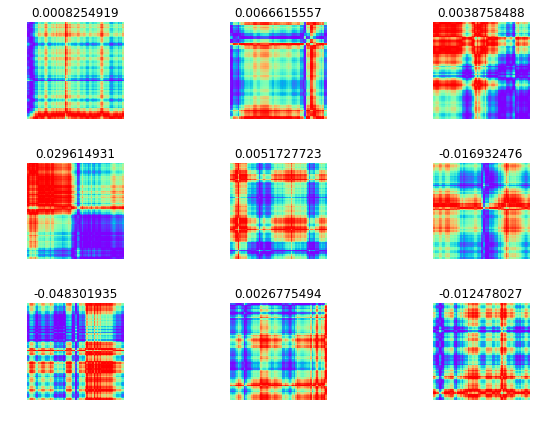

In [18]:
data_BBdiff.show_batch(3, figsize=(9,6))

In [19]:
learn_BBdiff = cnn_learner(data_BBdiff, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_BBdiff.load('BBdiff-stage1');

In [20]:
last_layers_BBdiff = list(children(learn_BBdiff.model))[-1][-1]
learn_BBdiff.model[-1] = learn_BBdiff.model[-1][:-1]
last_layers_BBdiff

Linear(in_features=512, out_features=1, bias=True)

In [21]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, x3, x4, y): 
        self.x1,self.x2,self.x3,self.x4,self.y = x1,x2,x3,x4,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): 
        imgTensor1 = self.x1[i].data
        imgTensor2 = self.x2[i].data
        imgTensor3 = self.x3[i].data
        imgTensor4 = self.x4[i].data
        y = torch.from_numpy(self.y[i].data)
        
        return (imgTensor1, imgTensor2, imgTensor3, imgTensor4), y

In [22]:
train_ds = ConcatDataset(data_CLOSE.train_ds.x, data_percentage.train_ds.x,
                         data_RSI.train_ds.x, data_BBdiff.train_ds.x,
                         data_CLOSE.train_ds.y)
valid_ds = ConcatDataset(data_CLOSE.valid_ds.x, data_percentage.valid_ds.x,
                         data_RSI.valid_ds.x, data_BBdiff.valid_ds.x,
                         data_CLOSE.valid_ds.y)

In [23]:
bs = 64
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)
data = DataBunch(train_dl, valid_dl)

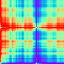

In [24]:
data.train_ds.x1[0]

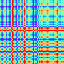

In [25]:
data.train_ds.x2[0]

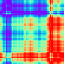

In [26]:
data.train_ds.x3[0]

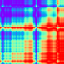

In [27]:
data.train_ds.x4[0]

In [28]:
class ConcatModel(nn.Module):
    def __init__(self, cnn_1, cnn_2, cnn_3, cnn_4, last_layers_1, last_layers_2, last_layers_3, last_layers_4):
        super().__init__()
        self.cnn_1 = cnn_1
        self.cnn_2 = cnn_2
        self.cnn_3 = cnn_3
        self.cnn_4 = cnn_4
               
        self.last_layers = nn.Linear(4*512, 1, True)
        self.last_layers.weight[0].data[0:512] = last_layers_1.weight[0].data
        self.last_layers.weight[0].data[512:2*512] = last_layers_2.weight[0].data
        self.last_layers.weight[0].data[2*512:3*512] = last_layers_3.weight[0].data
        self.last_layers.weight[0].data[3*512:4*512] = last_layers_4.weight[0].data
        
    def forward(self, x1, x2, x3, x4):
        x1 = self.cnn_1(x1)
        x2 = self.cnn_2(x2)
        x3 = self.cnn_3(x3)
        x4 = self.cnn_4(x4)
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last_layers(x)
        
        return x

In [29]:
model = ConcatModel(learn_CLOSE.model, learn_percentage.model, learn_RSI.model, learn_BBdiff.model, 
                    last_layers_CLOSE, last_layers_percentage, last_layers_RSI, last_layers_BBdiff)

In [30]:
layer_groups = [nn.Sequential(*flatten_model(learn_CLOSE.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_CLOSE.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_CLOSE.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_RSI.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_RSI.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_RSI.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_BBdiff.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_BBdiff.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_BBdiff.layer_groups[2]))] 

In [31]:
learn = Learner(data, model, metrics= [r2_score, root_mean_squared_error], layer_groups=layer_groups)

In [32]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.006002,0.000801,-0.788403,0.026557,02:31
1,0.006458,0.001249,-2.248553,0.030627,01:38
2,0.006250,0.002060,-3.683521,0.038961,01:38
3,0.005286,0.000824,-0.772277,0.027162,01:39
4,0.005304,0.000760,-0.843442,0.026260,01:38
5,0.005408,0.000856,-0.804171,0.027389,01:38
6,0.004883,0.000817,-0.801669,0.027081,01:38
7,0.005140,0.000752,-0.593243,0.025976,01:38
8,0.004560,0.000717,-0.546748,0.025433,01:39


In [33]:
learn.save('CLOSE+percentage+RSI+BBdiff-stage1')

In [34]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.004808,0.001146,-1.925044,0.031539,01:40
1,0.005066,0.001293,-1.989660,0.032513,01:38
2,0.004683,0.000702,-0.410764,0.024939,01:38


In [35]:
learn.save('CLOSE+percentage+RSI+BBdiff-stage2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


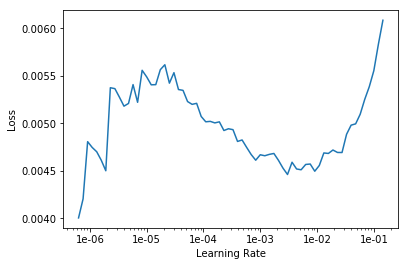

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.005014,0.000888,-0.913192,0.027908,01:40
1,0.004816,0.000820,-0.705211,0.027115,01:39
2,0.003812,0.000708,-0.496288,0.025273,01:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


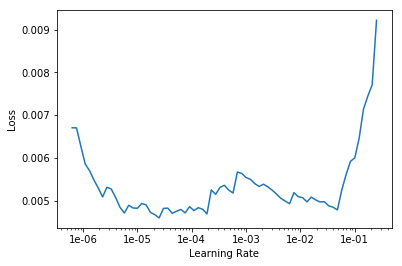

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.save('CLOSE+percentage+RSI+BBdiff-stage3')

In [41]:
learn.fit_one_cycle(6, max_lr = slice(3e-6,3e-4))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.004661,0.000701,-0.461280,0.025136,01:40
1,0.003698,0.000703,-0.460097,0.025200,01:38
2,0.004268,0.000697,-0.424796,0.024986,01:38
3,0.004360,0.000683,-0.408998,0.024760,01:39
4,0.004480,0.000718,-0.494083,0.025320,01:39
5,0.004456,0.000689,-0.427205,0.024874,01:38


In [42]:
learn.save('CLOSE+percentage+RSI+BBdiff-stage4')

In [32]:
learn.load('CLOSE+percentage+RSI+BBdiff-stage4');

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


https://docs.fast.ai/data_block.html#Add-a-test-set

In [47]:
data_CLOSE_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_CLOSE", valid = "test_CLOSE")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_percentage_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_percentage", valid = "test_percentage")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_RSI_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_RSI", valid = "test_RSI")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_BBdiff_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_BBdiff", valid = "test_BBdiff")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

train_ds = ConcatDataset(data_CLOSE_test.train_ds.x, data_percentage_test.train_ds.x,
                         data_RSI_test.train_ds.x, data_BBdiff_test.train_ds.x,
                         data_CLOSE_test.train_ds.y)
test_ds = ConcatDataset(data_CLOSE_test.valid_ds.x, data_percentage_test.valid_ds.x,
                        data_RSI_test.valid_ds.x, data_BBdiff_test.valid_ds.x,
                        data_CLOSE_test.valid_ds.y)

bs = 64
train_dl = DataLoader(train_ds, bs)
test_dl = DataLoader(test_ds, bs)
data_test = DataBunch(train_dl, test_dl)

In [48]:
data_test.test_dl

In [49]:
pred_metrics = learn.validate(data_test.test_dl)

In [50]:
pred_metrics

[0.00068878895, tensor(-0.4272), tensor(0.0249)]